In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('FluPrediction').getOrCreate()

# Tree classification

In [8]:
traintest = spark.read.csv("traintest2.csv", header=True, inferSchema=True)
traintest.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- ACTIVITYESTIMATE: string (nullable = true)
 |-- WEEK: integer (nullable = true)
 |-- POP: integer (nullable = true)
 |-- AREA: integer (nullable = true)
 |-- HealthCare_All: double (nullable = true)
 |-- HealthCare_Over65: double (nullable = true)
 |-- INCOME: integer (nullable = true)
 |-- TypeA_subH3: integer (nullable = true)
 |-- TypeA_subH1N1: integer (nullable = true)
 |-- TypeA: integer (nullable = true)
 |-- TypeA_subH3N2: integer (nullable = true)
 |-- TypeA_subU: integer (nullable = true)
 |-- TypeA_subH1: integer (nullable = true)
 |-- PrevWeek: string (nullable = true)
 |-- NSporadic: integer (nullable = true)
 |-- NLocalAct: integer (nullable = true)
 |-- NNoAct: integer (nullable = true)
 |-- NRegional: integer (nullable = true)
 |-- NWidespread: double (nullable = true)
 |-- Density: double (nullable = true)



In [9]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import (RandomForestClassifier, GBTClassifier, DecisionTreeClassifier)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#### Formating the data

In [10]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer)
from pyspark.ml.linalg import Vectors

In [11]:
State_indexer = StringIndexer(inputCol='STATENAME',outputCol='StateIndex')
State_encoder = OneHotEncoder(inputCol='StateIndex',outputCol='StateVec')

Activity_indexer = StringIndexer(inputCol='ACTIVITYESTIMATE',outputCol='ActivityIndex')
Activity_encoder = OneHotEncoder(inputCol='ActivityIndex',outputCol='ActivityVec')

Season_indexer = StringIndexer(inputCol='SEASON',outputCol='SeasonIndex')
Season_encoder = OneHotEncoder(inputCol='SeasonIndex',outputCol='SeasonVec')

PrevWeek_indexer = StringIndexer(inputCol='PrevWeek',outputCol='PrevWeekIndex')
PrevWeek_encoder = OneHotEncoder(inputCol='PrevWeekIndex',outputCol='PrevWeekVec')

In [12]:
assembler = VectorAssembler(
  inputCols=['WEEK',
             'POP',
             'AREA',
             'HealthCare_All',
             'HealthCare_Over65',
             'INCOME',
             'TypeA_subH3',
             'TypeA_subH1N1',
             'TypeA',
             'TypeA_subH3N2',
             'TypeA_subU',
             'TypeA_subH1',
             'PrevWeekVec',
             'NSporadic',
             'NLocalAct',
             'NNoAct',
             'NRegional',
             'NWidespread',
             'Density'],
    outputCol="features")


In [13]:
dt = DecisionTreeClassifier(labelCol="ActivityIndex", featuresCol="features", maxDepth=5, maxBins=40,minInstancesPerNode=11)
pipeline = Pipeline(stages=[Activity_indexer,PrevWeek_indexer,
                           Activity_encoder,PrevWeek_encoder,
                           assembler,dt])

(train, test) = traintest.randomSplit([0.9, 0.1])

fit_model = pipeline.fit(train)

In [14]:
prediction_dt = fit_model.transform(test)

In [15]:
evaluator = MulticlassClassificationEvaluator(labelCol="ActivityIndex", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(prediction_dt)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.20633


In [35]:
prediction_dt

DataFrame[_c0: int, ACTIVITYESTIMATE: string, WEEK: int, POP: int, AREA: int, HealthCare_All: double, HealthCare_Over65: double, INCOME: int, TypeA_subH3: int, TypeA_subH1N1: int, TypeA: int, TypeA_subH3N2: int, TypeA_subU: int, TypeA_subH1: int, PrevWeek: string, NSporadic: int, NLocalAct: int, NNoAct: int, NRegional: int, NWidespread: int, ActivityIndex: double, PrevWeekIndex: double, ActivityVec: vector, PrevWeekVec: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]

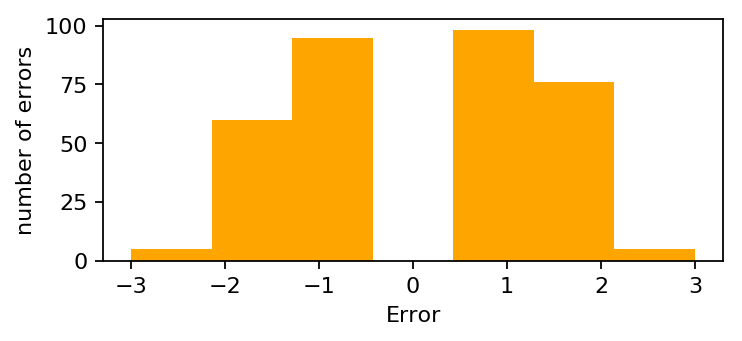

In [19]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
figure(num=None, figsize=(5, 2), dpi=160, facecolor='w', edgecolor='k')
PR = prediction_dt.toPandas()['prediction']
PR[PR == 0] = 7
PR[PR == 1] = 5
PR[PR == 2] = 8
PR[PR == 3] = 6
PR[PR == 4] = 9
PR = PR -5

tart =  prediction_dt.toPandas()['ActivityIndex']

tart[tart == 0] = 7
tart[tart == 1] = 5
tart[tart == 2] = 8
tart[tart == 3] = 6
tart[tart == 4] = 9
tart = tart -5
plt.hist((tart - PR)[(tart - PR)!=0],bins=7,color = 'orange')
plt.xlabel('Error')
plt.ylabel('number of errors')
plt.show()


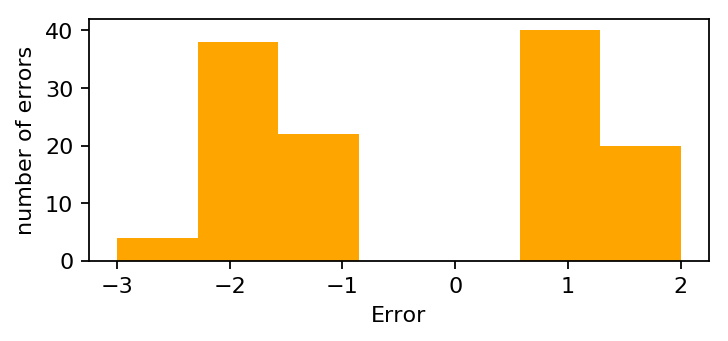

In [59]:
figure(num=None, figsize=(5, 2), dpi=160, facecolor='w', edgecolor='k')
PR = prediction_dt.filter('WEEK >=40').toPandas()['prediction']
PR[PR == 0] = 7
PR[PR == 1] = 5
PR[PR == 2] = 8
PR[PR == 3] = 6
PR[PR == 4] = 9
PR = PR -5

tart =  prediction_dt.filter('WEEK >=40').toPandas()['ActivityIndex']

tart[tart == 0] = 7
tart[tart == 1] = 5
tart[tart == 2] = 8
tart[tart == 3] = 6
tart[tart == 4] = 9
tart = tart -5
plt.hist((tart - PR)[(tart - PR)!=0],bins=7,color = 'orange')
plt.xlabel('Error')
plt.ylabel('number of errors')
plt.show()

In [15]:
feature_importances = fit_model.stages[-1].featureImportances
feature_imp_array = feature_importances.toArray()
feature_imp_array

array([0.00485465, 0.00530204, 0.00464696, 0.00389332, 0.00392441,
       0.00412762, 0.04309729, 0.0082797 , 0.00606024, 0.        ,
       0.        , 0.        , 0.27850216, 0.39357184, 0.11779743,
       0.11668011, 0.00050537, 0.00345439, 0.        , 0.00066314,
       0.00463933])

In [16]:
import pandas as pd
dataset = fit_model.transform(train)

pandasDF = pd.DataFrame(dataset.schema["features"].metadata["ml_attr"] 
["attrs"]["binary"]+dataset.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

feature_dict = dict(zip(pandasDF["idx"],pandasDF["name"])) 
feature_dict_broad = spark.sparkContext.broadcast(feature_dict)

import numpy as np
pandasDF['imp'] = np.sort(feature_imp_array)

In [17]:
pandasDF = pandasDF.sort_values("imp",ascending =False)[1:30]
pandasDF = pandasDF.sort_values("imp",ascending =True)

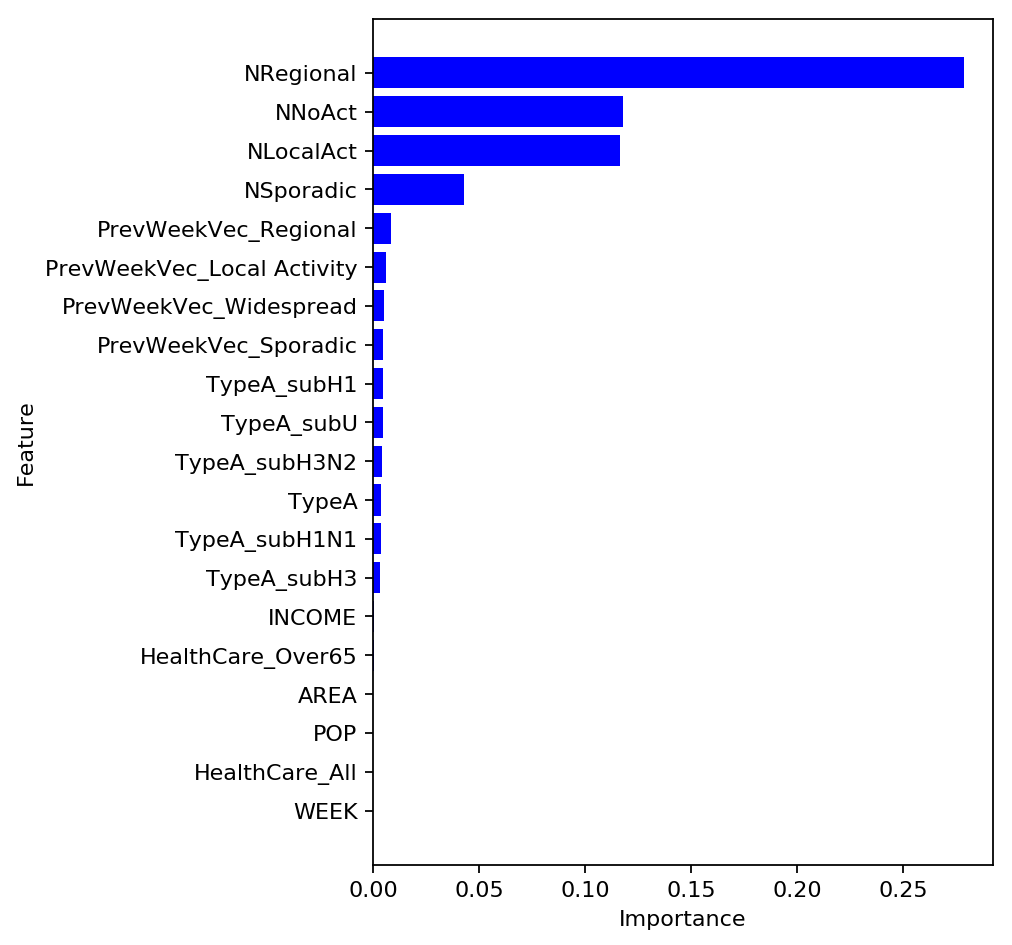

In [19]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(5, 7), dpi=160, facecolor='w', edgecolor='k')
plt.barh(pandasDF['name'],pandasDF['imp'], color='b', align='center',)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


###  Parameter tunning

In [8]:
A = []

for k in range(3,10) : 
    dt = DecisionTreeClassifier(labelCol="ActivityIndex", featuresCol="features", maxDepth=k, maxBins=32,minInstancesPerNode=7)
    pipeline = Pipeline(stages=[Activity_indexer,PrevWeek_indexer,
                               PrevWeek_encoder,
                               assembler,dt])

    (train, test) = traintest.randomSplit([0.9, 0.1])

    fit_model = pipeline.fit(train)

    prediction_dt = fit_model.transform(test)

    evaluator = MulticlassClassificationEvaluator(labelCol="ActivityIndex", predictionCol="prediction", metricName="accuracy")
    A.append(evaluator.evaluate(prediction_dt))


In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
figure(num=None, figsize=(5, 4), dpi=160, facecolor='w', edgecolor='k')
plt.plot(np.linspace(3,10,7),A)
plt.xlabel('maxDepth')
plt.ylabel('Accuracy')
plt.show()

NameError: name 'A' is not defined

In [13]:
A2 = []

for k in range(8,15) : 
    dt = DecisionTreeClassifier(labelCol="ActivityIndex", featuresCol="features", maxDepth=5, maxBins=3*k,minInstancesPerNode=7)
    pipeline = Pipeline(stages=[Activity_indexer,PrevWeek_indexer,
                               PrevWeek_encoder,
                               assembler,dt])

    (train, test) = traintest.randomSplit([0.9, 0.1])

    fit_model = pipeline.fit(train)

    prediction_dt = fit_model.transform(test)

    evaluator = MulticlassClassificationEvaluator(labelCol="ActivityIndex", predictionCol="prediction", metricName="accuracy")
    A2.append(evaluator.evaluate(prediction_dt))

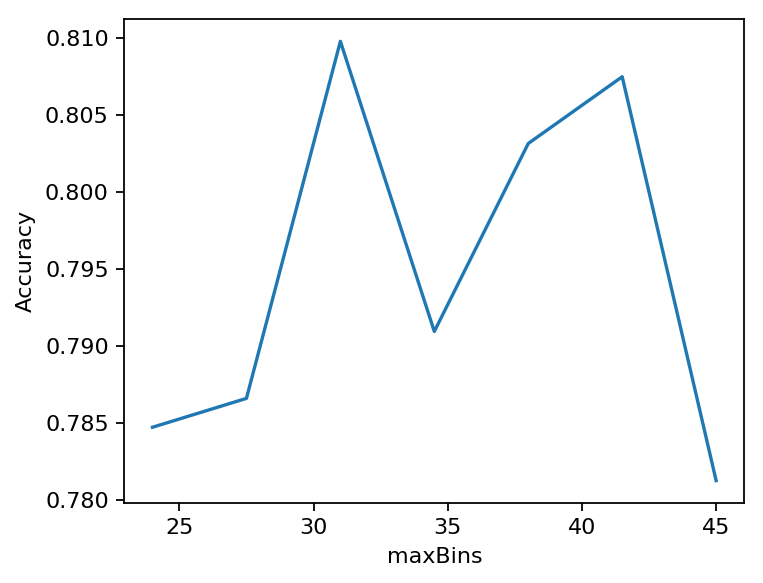

In [23]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
figure(num=None, figsize=(5, 4), dpi=160, facecolor='w', edgecolor='k')
plt.plot(np.linspace(24,45,7),A2)
plt.xlabel('maxBins')
plt.ylabel('Accuracy')
plt.show()

In [17]:
A3 = []

for k in range(3,12) : 
    dt = DecisionTreeClassifier(labelCol="ActivityIndex", featuresCol="features", maxDepth=5, maxBins=33,minInstancesPerNode=k)
    pipeline = Pipeline(stages=[Activity_indexer,PrevWeek_indexer,
                               PrevWeek_encoder,
                               assembler,dt])

    (train, test) = traintest.randomSplit([0.9, 0.1])

    fit_model = pipeline.fit(train)

    prediction_dt = fit_model.transform(test)

    evaluator = MulticlassClassificationEvaluator(labelCol="ActivityIndex", predictionCol="prediction", metricName="accuracy")
    A3.append(evaluator.evaluate(prediction_dt))

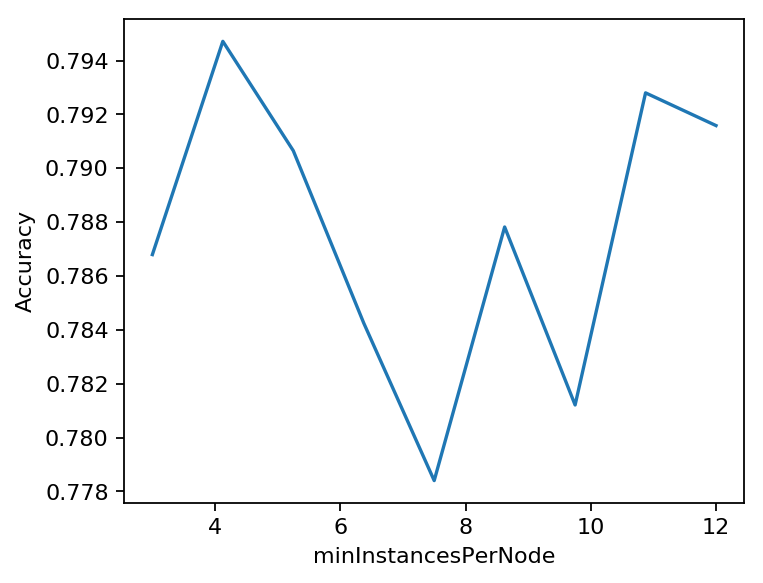

In [24]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
figure(num=None, figsize=(5, 4), dpi=160, facecolor='w', edgecolor='k')
plt.plot(np.linspace(3,12,9),A3)
plt.xlabel('minInstancesPerNode')
plt.ylabel('Accuracy')
plt.show()

In [69]:
from pyspark.ml.classification import NaiveBayes

NB = NaiveBayes(smoothing=1, modelType="multinomial")

pipeline = Pipeline(stages=[Activity_indexer,PrevWeek_indexer,
                           Activity_encoder,PrevWeek_encoder,
                           assembler,dt])

(train, test) = traintest.randomSplit([0.9, 0.1])

fit_model = pipeline.fit(train)


prediction_dt = fit_model.transform(test)

evaluator = MulticlassClassificationEvaluator(labelCol="ActivityIndex", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(prediction_dt)
print(accuracy)

0.7879161528976573
